In [1]:
!pip install --no-cache-dir transformers huggingface_hub==0.27.0 datasets accelerate nltk

In [2]:
# Standard library
import json
from time import sleep
from collections import Counter

# Third-party
import numpy as np
import requests
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.metrics import (
    classification_report,
    f1_score,
    hamming_loss,
    accuracy_score
)

# HuggingFace / Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    RobertaForSequenceClassification
)

# Datasets
from datasets import load_dataset, Dataset

In [3]:
ds = load_dataset("lex_glue", "eurlex")

In [4]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 55000
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 5000
    })
})


In [5]:
example = ds["train"][0]
example

{'text': 'COUNCIL DECISION\nof 7 June 2005\nabrogating Decision 2005/136/EC on the existence of an excessive deficit in the Netherlands\n(2005/729/EC)\nTHE COUNCIL OF THE EUROPEAN UNION,\nHaving regard to the Treaty establishing the European Community, and in particular Article 104(12) thereof,\nHaving regard to the recommendation from the Commission,\nWhereas:\n(1)\nBy Decision 2005/136/EC (1) following a recommendation from the Commission in accordance with Article 104(6) of the Treaty, the Council decided that an excessive deficit existed in the Netherlands.\n(2)\nIn accordance with Article 104(7) of the Treaty, the Council made a Recommendation on 2 June 2004 addressed to the Netherlands with a view to bringing the excessive deficit situation to an end. This Recommendation, in conjunction with Article 3(4) of Council Regulation (EC) No 1467/97 of 7 July 1997 on speeding up and clarifying the implementation of the excessive deficit procedure (2), established a deadline of 2005 at th

In [6]:
label2name = ds["train"].features["labels"].feature.names

c=0
for i, name in enumerate(label2name):
    if not c==5:
        print(i, name)
    else:
        break
    c+=1

0 100163
1 100168
2 100169
3 100170
4 100171


In [7]:
#---------------------------Fetch label from EuroVoc SPARQL endpoint------------------------------------------
def get_eurovoc_label(concept_id):
    """Fetch label from EuroVoc SPARQL endpoint"""
    sparql_endpoint = "http://publications.europa.eu/webapi/rdf/sparql"
    
    query = f"""
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
    SELECT ?label
    WHERE {{
      <http://eurovoc.europa.eu/{concept_id}> skos:prefLabel ?label .
      FILTER(lang(?label) = 'en')
    }}
    """
    
    try:
        response = requests.get(
            sparql_endpoint,
            params={'query': query, 'format': 'json'},
            timeout=10
        )
        if response.status_code == 200:
            data = response.json()
            if data['results']['bindings']:
                return data['results']['bindings'][0]['label']['value']
    except Exception as e:
        print(f"Error for {concept_id}: {e}")
    
    return concept_id

# Build mapping with rate limiting
label2description = {}
for i, concept_id in enumerate(label2name):
    label2description[concept_id] = get_eurovoc_label(concept_id)
    print(f"{concept_id}: {label2description[concept_id]}")
    if i % 10 == 0:  # Add delay every 10 requests
        sleep(1)

100163: 0406 political framework
100168: 0431 politics and public safety
100169: 0436 executive power and public service
100170: 0806 international affairs
100171: 0811 cooperation policy
100172: 0816 international security
100173: 0821 defence
100174: 1006 EU institutions and European civil service
100175: 1011 European Union law
100176: 1016 European construction
100177: 1021 EU finance
100179: 1211 civil law
100180: 1216 criminal law
100183: 1231 international law
100184: 1236 rights and freedoms
100185: 1606 economic policy
100186: 1611 economic conditions
100187: 1616 regions and regional policy
100189: 1626 national accounts
100190: 1631 economic analysis
100191: 2006 trade policy
100192: 2011 tariff policy
100193: 2016 trade
100194: 2021 international trade
100195: 2026 consumption
100196: 2031 marketing
100197: 2036 distributive trades
100198: 2406 monetary relations
100199: 2411 monetary economics
100200: 2416 financial institutions and credit
100201: 2421 free movement of cap

In [8]:
len(label2description)

100

In [9]:
#---------------------------High-level category aggregation for EuroVoc classes------------------------------------------
high_level_categories = {
    "Politics & Government": {
        "100163", "100168", "100169", "100174", "100175", "100176", "100177"
    },
    
    "International Affairs & Defense": {
        "100170", "100171", "100172", "100173", "100183", "100285"
    },
    
    "Law & Justice": {
        "100179", "100180", "100184"
    },
    
    "Economics & Finance": {
        "100185", "100186", "100189", "100190", "100198", "100199", "100200", 
        "100201", "100202", "100204", "100205", "100206", "100207"
    },
    
    "Trade & Business": {
        "100191", "100192", "100193", "100194", "100195", "100196", "100197",
        "100226", "100227", "100229", "100230", "100231"
    },
    
    "Employment & Labor": {
        "100232", "100233", "100234", "100235"
    },
    
    "Social Affairs & Health": {
        "100212", "100214", "100215"
    },
    
    "Technology & Science": {
        "100220", "100221", "100222", "100223", "100224", "100261", "100262"
    },
    
    "Transportation": {
        "100237", "100238", "100239", "100240", "100241"
    },
    
    "Environment": {
        "100242", "100243", "100244"
    },
    
    "Agriculture & Food": {
        "100245", "100246", "100247", "100248", "100249", "100250", "100252",
        "100253", "100254", "100255", "100256", "100257", "100258", "100259"
    },
    
    "Energy & Resources": {
        "100263", "100264", "100265", "100266"
    },
    
    "Industry & Manufacturing": {
        "100260", "100268", "100269", "100270", "100271", "100272", "100273",
        "100274", "100275", "100276"
    },
    
    "Geography & Regional": {
        "100187", "100277", "100278", "100279", "100280", "100281", "100282",
        "100283", "100284"
    },
}

# Verify all classes are mapped
all_mapped = set()
for classes in high_level_categories.values():
    all_mapped.update(classes)

all_labels = set(label2name)
unmapped = all_labels - all_mapped

print(f"Total labels: {len(all_labels)}")
print(f"Mapped labels: {len(all_mapped)}")
print(f"Unmapped labels: {unmapped if unmapped else 'None'}")

# Print the mapping
print("\n=== High-Level Category Mapping ===")
for category, classes in high_level_categories.items():
    print(f"\n{category}: {len(classes)} classes")
    for class_id in sorted(classes):
        print(f"  - {class_id}: {label2description.get(class_id, 'Unknown')}")

Total labels: 100
Mapped labels: 100
Unmapped labels: None

=== High-Level Category Mapping ===

Politics & Government: 7 classes
  - 100163: 0406 political framework
  - 100168: 0431 politics and public safety
  - 100169: 0436 executive power and public service
  - 100174: 1006 EU institutions and European civil service
  - 100175: 1011 European Union law
  - 100176: 1016 European construction
  - 100177: 1021 EU finance

International Affairs & Defense: 6 classes
  - 100170: 0806 international affairs
  - 100171: 0811 cooperation policy
  - 100172: 0816 international security
  - 100173: 0821 defence
  - 100183: 1231 international law
  - 100285: 7606 United Nations

Law & Justice: 3 classes
  - 100179: 1211 civil law
  - 100180: 1216 criminal law
  - 100184: 1236 rights and freedoms

Economics & Finance: 13 classes
  - 100185: 1606 economic policy
  - 100186: 1611 economic conditions
  - 100189: 1626 national accounts
  - 100190: 1631 economic analysis
  - 100198: 2406 monetary rela

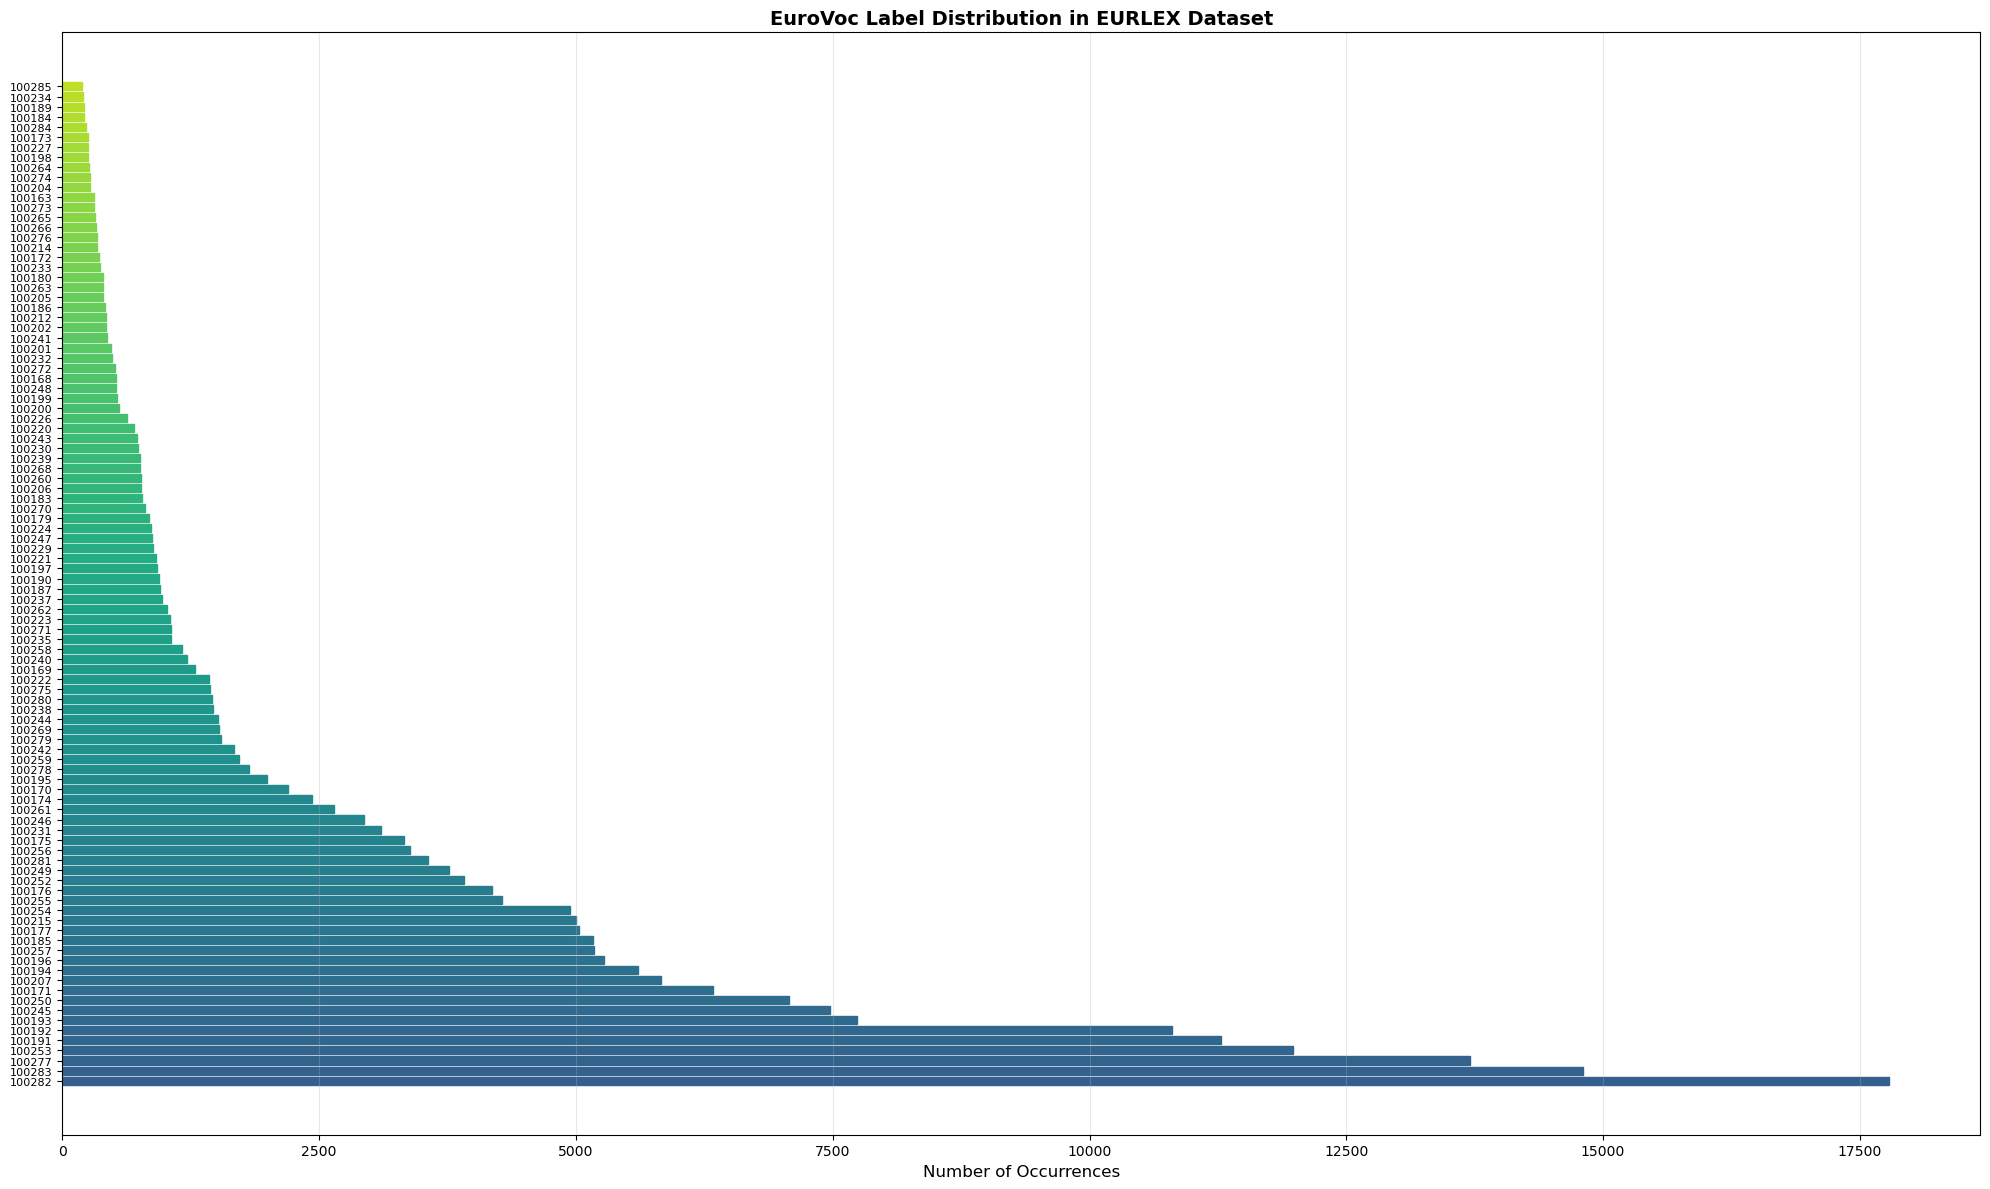


=== Dataset Statistics ===
Total examples: 55000
Total labels: 100
Total label occurrences: 243349
Average labels per document: 4.42

Top 10 most frequent labels:
  100282: 17781 (32.3%)
  100283: 14803 (26.9%)
  100277: 13702 (24.9%)
  100253: 11982 (21.8%)
  100191: 11277 (20.5%)
  100192: 10804 (19.6%)
  100193: 7739 (14.1%)
  100245: 7470 (13.6%)
  100250: 7072 (12.9%)
  100171: 6335 (11.5%)


In [10]:
#---------------------------labels occurence in the dataset------------------------------------------
# Count label occurrences (handling multi-label)
label_counts = Counter()

for example in ds["train"]:
    for label in example["labels"]:
        label_counts[label] += 1

# Get label names
label2name = ds["train"].features["labels"].feature.names

# Prepare data for plotting
labels = []
counts = []
for label_id, count in label_counts.most_common():
    label_name = label2name[label_id]
    labels.append(f"{label_name}")
    counts.append(count)

# Create the plot
plt.figure(figsize=(20, 12))
bars = plt.barh(range(len(labels)), counts)

# Color bars by frequency (darker = more frequent)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(labels)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.yticks(range(len(labels)), labels, fontsize=8)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.title('EuroVoc Label Distribution in EURLEX Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
plt.show()

# Print statistics
print(f"\n=== Dataset Statistics ===")
print(f"Total examples: {len(ds['train'])}")
print(f"Total labels: {len(label_counts)}")
print(f"Total label occurrences: {sum(label_counts.values())}")
print(f"Average labels per document: {sum(label_counts.values()) / len(ds['train']):.2f}")
print(f"\nTop 10 most frequent labels:")
for label_id, count in label_counts.most_common(10):
    label_name = label2name[label_id]
    print(f"  {label_name}: {count} ({count/len(ds['train'])*100:.1f}%)")

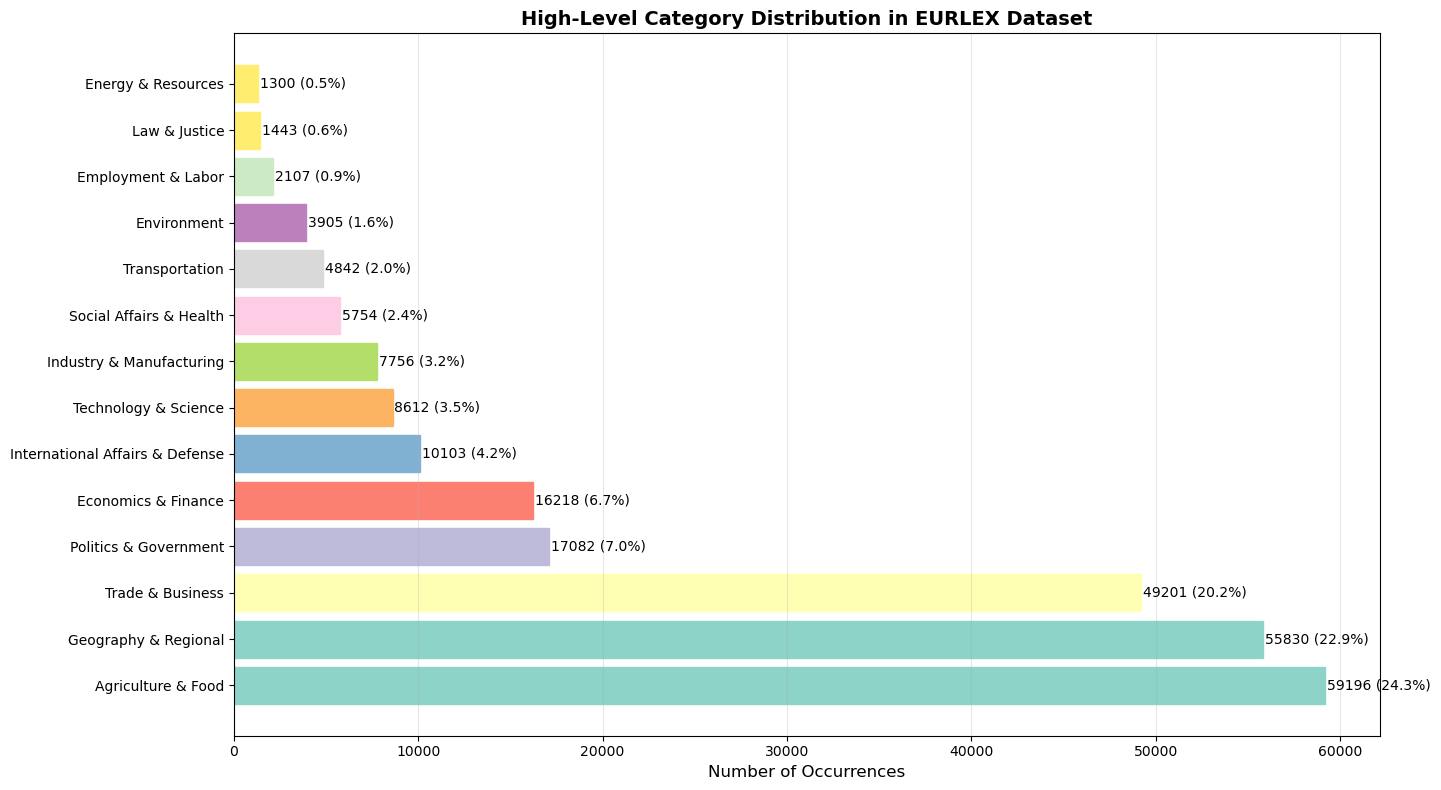

In [11]:
#------------------------------------------------------high level labels occurence in the dataset----------------------
# Create reverse mapping: label_id -> high_level_category
label_to_category = {}
for category, label_set in high_level_categories.items():
    for label_id in label_set:
        label_to_category[label_id] = category

# Count high-level category occurrences
category_counts = Counter()
for example in ds["train"]:
    for label_idx in example["labels"]:
        label_id = label2name[label_idx]
        category = label_to_category.get(label_id, "Other")
        category_counts[category] += 1

# Calculate total for percentages
total_count = sum(category_counts.values())

# Plot high-level categories
categories = [cat for cat, _ in category_counts.most_common()]
counts = [count for _, count in category_counts.most_common()]

plt.figure(figsize=(14, 8))
bars = plt.barh(categories, counts)

# Color bars
colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.xlabel('Number of Occurrences', fontsize=12)
plt.title('High-Level Category Distribution in EURLEX Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.grid(axis='x', alpha=0.3)

# Add count labels and percentages on bars
for i, (category, count) in enumerate(zip(categories, counts)):
    percentage = (count / total_count) * 100
    label = f'{count} ({percentage:.1f}%)'
    plt.text(count + 100, i, label, va='center', fontsize=10)

plt.show()

In [12]:
#------------------------------------------------------Create mappings----------------------
category_names = list(high_level_categories.keys())
category_to_id = {cat: idx for idx, cat in enumerate(category_names)}
id_to_category = {idx: cat for cat, idx in category_to_id.items()}

label_to_category_id = {}
for category, label_set in high_level_categories.items():
    for label_id in label_set:
        label_to_category_id[label_id] = category_to_id[category]

print(f"\nHigh-level categories: {len(category_names)}")
for cat in category_names:
    print(f"  - {cat}")


High-level categories: 14
  - Politics & Government
  - International Affairs & Defense
  - Law & Justice
  - Economics & Finance
  - Trade & Business
  - Employment & Labor
  - Social Affairs & Health
  - Technology & Science
  - Transportation
  - Environment
  - Agriculture & Food
  - Energy & Resources
  - Industry & Manufacturing
  - Geography & Regional


In [13]:
#------------------------------------------------------convert labels to multi-hot vector----------------------
def transform_to_multilabel(example):
    """Convert fine-grained labels into a multi-hot vector of high-level categories"""
    vector = np.zeros(len(category_names), dtype=int)
    for label_idx in example["labels"]:
        label_id = label2name[label_idx]
        if label_id in label_to_category_id:
            vector[label_to_category_id[label_id]] = 1
    return {"text": example["text"], "labels": vector.tolist()}

train_data = [transform_to_multilabel(ex) for ex in ds["train"]]
val_data = [transform_to_multilabel(ex) for ex in ds["validation"]]
test_data = [transform_to_multilabel(ex) for ex in ds["test"]]

In [14]:
print(f"\nDataset sizes after transformation:")
print(f"  Train: {len(train_data)}")
print(f"  Val: {len(val_data)}")
print(f"  Test: {len(test_data)}")


Dataset sizes after transformation:
  Train: 55000
  Val: 5000
  Test: 5000


In [15]:
#------------------------------------------------------Remove unmapped (-1 labels)----------------------
train_data = [ex for ex in train_data if ex["labels"] != -1]
val_data = [ex for ex in val_data if ex["labels"] != -1]
test_data = [ex for ex in test_data if ex["labels"] != -1]

print(f"\nDataset sizes after transformation:")
print(f"  Train: {len(train_data)}")
print(f"  Val: {len(val_data)}")
print(f"  Test: {len(test_data)}")


Dataset sizes after transformation:
  Train: 55000
  Val: 5000
  Test: 5000


In [16]:
# Count occurrences of each category across all documents
category_document_counts = Counter()

for ex in train_data:
    labels_array = ex["labels"]
    for idx, value in enumerate(labels_array):
        if value == 1:  # Only count when the label is present
            category_document_counts[idx] += 1

print("\n=== Multi-label Category Distribution (Documents) ===")
for label_id in sorted(category_document_counts.keys()):
    count = category_document_counts[label_id]
    category_name = id_to_category[label_id]
    percentage = (count / len(train_data)) * 100
    print(f"{category_name}: {count} documents ({percentage:.1f}%)")

print(f"\nTotal training documents: {len(train_data)}")

# Also check the structure of your labels
print("\n=== Label Structure Check ===")
print(f"Number of categories: {len(category_names)}")
print(f"Sample labels (first 5 documents):")
for i, ex in enumerate(train_data[:5]):
    active_categories = [id_to_category[idx] for idx, val in enumerate(ex["labels"]) if val == 1]
    print(f"  Doc {i}: {active_categories}")

# Verify label vector length
label_lengths = [len(ex["labels"]) for ex in train_data]
print(f"\nLabel vector lengths - Min: {min(label_lengths)}, Max: {max(label_lengths)}")
if len(set(label_lengths)) > 1:
    print("WARNING: Inconsistent label vector lengths!")


=== Multi-label Category Distribution (Documents) ===
Politics & Government: 14479 documents (26.3%)
International Affairs & Defense: 9165 documents (16.7%)
Law & Justice: 1318 documents (2.4%)
Economics & Finance: 14201 documents (25.8%)
Trade & Business: 33539 documents (61.0%)
Employment & Labor: 1854 documents (3.4%)
Social Affairs & Health: 5670 documents (10.3%)
Technology & Science: 7074 documents (12.9%)
Transportation: 3307 documents (6.0%)
Environment: 3104 documents (5.6%)
Agriculture & Food: 37255 documents (67.7%)
Energy & Resources: 1101 documents (2.0%)
Industry & Manufacturing: 6844 documents (12.4%)
Geography & Regional: 23346 documents (42.4%)

Total training documents: 55000

=== Label Structure Check ===
Number of categories: 14
Sample labels (first 5 documents):
  Doc 0: ['Economics & Finance', 'Geography & Regional']
  Doc 1: ['International Affairs & Defense', 'Trade & Business', 'Agriculture & Food']
  Doc 2: ['Politics & Government', 'Economics & Finance', 'Te

In [20]:
import json
with open("news_multilabel_train.json", "w", encoding="utf-8") as f:
    json.dump(train_data, f, ensure_ascii=False, indent=4)

In [21]:
import json
with open("news_multilabel_validation.json", "w", encoding="utf-8") as f:
    json.dump(val_data, f, ensure_ascii=False, indent=4)

In [22]:
import json
with open("news_multilabel_test.json", "w", encoding="utf-8") as f:
    json.dump(test_data, f, ensure_ascii=False, indent=4)

In [25]:
import json
with open("id_to_category.json", "w", encoding="utf-8") as f:
    json.dump(id_to_category, f, ensure_ascii=False, indent=4)